In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext,SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import when

In [2]:
happiness = pd.read_csv("data/happiness_2019.csv")
homicide = pd.read_csv("data/homicide-rate.csv")
subregion = pd.read_csv("data/subregion.csv")

In [3]:
happiness = happiness.filter(items=['Overall rank', 'Country or region', 'Score', 'GDP per capita', 'Social support',
                       'Healthy life expectancy', 'Freedom to make life choices', 'Generosity',
                       'Perceptions of corruption']).rename(columns = {'Overall rank':'rank',
                                                                      'Country or region':'country',
                                                                       'Score':'score',
                                                                      'GDP per capita': 'GDP',
                                                                      'Social support': 'support',
                                                                      'Healthy life expectancy': 'healthy',
                                                                      'Freedom to make life choices': 'freedom',
                                                                      'Generosity':'generosity',
                                                                      'Perceptions of corruption':'corruption'})

In [4]:
homicide = homicide[homicide['Year']==2019].filter(items=['Entity','Code',
                                  'Deaths - Interpersonal violence - Sex: Both - Age: All Ages (Rate)']).rename(columns = {
    'Deaths - Interpersonal violence - Sex: Both - Age: All Ages (Rate)':'deaths'
}).reset_index()

In [5]:
homicide = homicide.dropna().filter(items=['Entity','Code','deaths'])

In [6]:
subregion = subregion.filter(items=['name','region',
                                    'sub-region']).dropna(axis=0).rename(columns = {'sub-region':'subregion'})

In [7]:
subregion.head(5)

,name,region,subregion
0,Afghanistan,Asia,Southern Asia
1,Åland Islands,Europe,Northern Europe
2,Albania,Europe,Southern Europe
3,Algeria,Africa,Northern Africa
4,American Samoa,Oceania,Polynesia


In [8]:
sc.stop()
sc = SparkContext(appName="si618p1ml")
sqlc = SQLContext(sc)

/sw/pkgs/arc/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [10]:
df_happiness = sqlc.createDataFrame(happiness)
df_homicide = sqlc.createDataFrame(homicide)
df_subregion = sqlc.createDataFrame(subregion)

In [11]:
df_happiness.createOrReplaceTempView("happiness")
df_homicide.createOrReplaceTempView("homicide")
df_subregion.createOrReplaceTempView("subregion")

In [12]:
happyfactor = sqlc.sql('''
SELECT happiness.rank, happiness.country, happiness.score, happiness.GDP, happiness.support,
happiness.healthy, happiness.freedom, happiness.generosity, happiness.corruption, homicide.Code,
homicide.deaths, subregion.region AS continent,subregion.subregion FROM happiness
LEFT OUTER JOIN homicide
ON homicide.Entity=happiness.country
LEFT OUTER JOIN subregion
ON subregion.name=happiness.country
ORDER BY happiness.rank
''')
happyfactor.createOrReplaceTempView("happyfactor")

In [13]:
happyfactor.show(5)

+----+-----------+-----+-----+-------+-------+-------+----------+----------+----+------+---------+---------------+
|rank|    country|score|  GDP|support|healthy|freedom|generosity|corruption|Code|deaths|continent|      subregion|
+----+-----------+-----+-----+-------+-------+-------+----------+----------+----+------+---------+---------------+
|   1|    Finland|7.769| 1.34|  1.587|  0.986|  0.596|     0.153|     0.393| FIN|  1.49|   Europe|Northern Europe|
|   2|    Denmark|  7.6|1.383|  1.573|  0.996|  0.592|     0.252|      0.41| DNK|  0.75|   Europe|Northern Europe|
|   3|     Norway|7.554|1.488|  1.582|  1.028|  0.603|     0.271|     0.341| NOR|  0.61|   Europe|Northern Europe|
|   4|    Iceland|7.494| 1.38|  1.624|  1.026|  0.591|     0.354|     0.118| ISL|  0.68|   Europe|Northern Europe|
|   5|Netherlands|7.488|1.396|  1.522|  0.999|  0.557|     0.322|     0.298| NLD|  0.84|   Europe| Western Europe|
+----+-----------+-----+-----+-------+-------+-------+----------+----------+----

In [14]:
happy_df = happyfactor.toPandas()

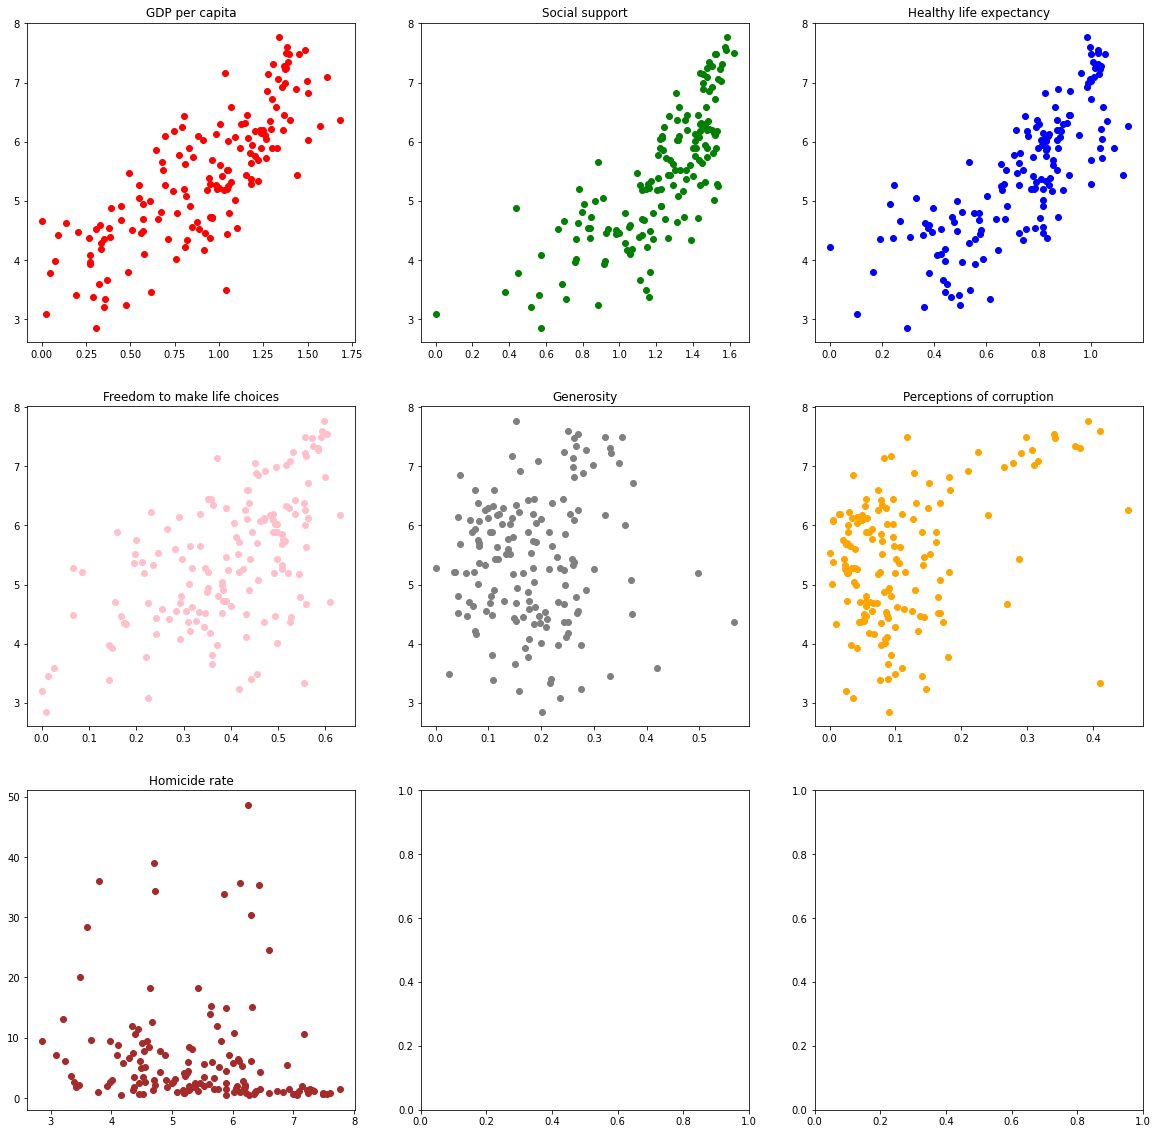

In [15]:
figure, axis = plt.subplots(nrows=3, ncols=3,figsize=(20,20))
axis[0, 0].scatter(happy_df['GDP'], happy_df['score'],color='red')
axis[0, 0].set_title("GDP per capita")

axis[0, 1].scatter(happy_df['support'], happy_df['score'],c='green')
axis[0, 1].set_title("Social support")

axis[0, 2].scatter(happy_df['healthy'], happy_df['score'],c='blue')
axis[0, 2].set_title("Healthy life expectancy")

axis[1, 0].scatter(happy_df['freedom'], happy_df['score'],c='pink')
axis[1, 0].set_title("Freedom to make life choices")

axis[1, 1].scatter(happy_df['generosity'], happy_df['score'],c='grey')
axis[1, 1].set_title("Generosity")

axis[1, 2].scatter(happy_df['corruption'], happy_df['score'],c='orange')
axis[1, 2].set_title("Perceptions of corruption")

axis[2, 0].scatter(happy_df['score'], happy_df['deaths'],c='brown')
axis[2, 0].set_title("Homicide rate")

plt.show()

In [16]:
kGDP, mGDP = np.polyfit(happy_df['GDP'],happy_df['score'],deg=1)
ksupport, msupport = np.polyfit(happy_df['support'],happy_df['score'],deg=1)
khealthy, mhealthy = np.polyfit(happy_df['healthy'],happy_df['score'],deg=1)

In [17]:
kGDP, ksupport, khealthy

(2.218148001008357, 2.8909870440102265, 3.5853671444308874)

In [18]:
linearlist = happyfactor.rdd.map(lambda line:
                    ((line[1],line[2]), 
                     (kGDP*line[3]+mGDP,
                    ksupport*line[4]+msupport,
                    khealthy*line[5]+mhealthy))).map(lambda line:
                                                     (line[0],line[1][0]+line[1][1]+line[1][2])).collect()

In [19]:
scores = []
scaled = []
for l in linearlist:
    scores.append(l[0][1])
    scaled.append(l[1])

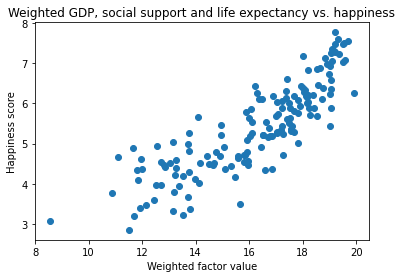

In [20]:
plt.scatter(scaled, scores)
plt.title("Weighted GDP, social support and life expectancy vs. happiness")
plt.xlabel("Weighted factor value")
plt.ylabel("Happiness score")
plt.show()

In [21]:
region_avg = sqlc.sql('''
SELECT continent, subregion, COUNT(score) AS sample_number, ROUND(AVG(score),5) AS avg_score, 
ROUND(AVG(GDP),5) AS avg_GDP, ROUND(AVG(support),5) AS avg_support,
ROUND(AVG(healthy),5) AS avg_healthy, ROUND(AVG(freedom),5) AS avg_freedom, 
ROUND(AVG(generosity),5) AS avg_generosity, ROUND(AVG(corruption),5) AS avg_corruption, 
ROUND(AVG(deaths),5) AS avg_deaths FROM happyfactor
GROUP BY continent, subregion
ORDER BY avg_score DESC
''')
region_avg.createOrReplaceTempView("regionavg")

In [22]:
region_avg.show(5)

+---------+--------------------+-------------+---------+-------+-----------+-----------+-----------+--------------+--------------+----------+
|continent|           subregion|sample_number|avg_score|avg_GDP|avg_support|avg_healthy|avg_freedom|avg_generosity|avg_corruption|avg_deaths|
+---------+--------------------+-------------+---------+-------+-----------+-----------+-----------+--------------+--------------+----------+
|  Oceania|Australia and New...|            2|   7.2675| 1.3375|     1.5525|      1.031|      0.571|         0.331|         0.335|     1.295|
|   Europe|      Western Europe|            7|  7.11486|1.41229|    1.49029|    1.01386|      0.513|       0.22214|         0.263|   0.90286|
| Americas|    Northern America|            2|    7.085|  1.399|      1.481|     0.9565|      0.519|        0.2825|         0.218|     3.455|
|   Europe|     Northern Europe|           10|   6.9817| 1.3472|     1.5452|     0.9544|     0.4972|        0.2164|         0.249|     2.276|
| Amer

In [23]:
regionavg_df = region_avg.toPandas().dropna(axis=0)

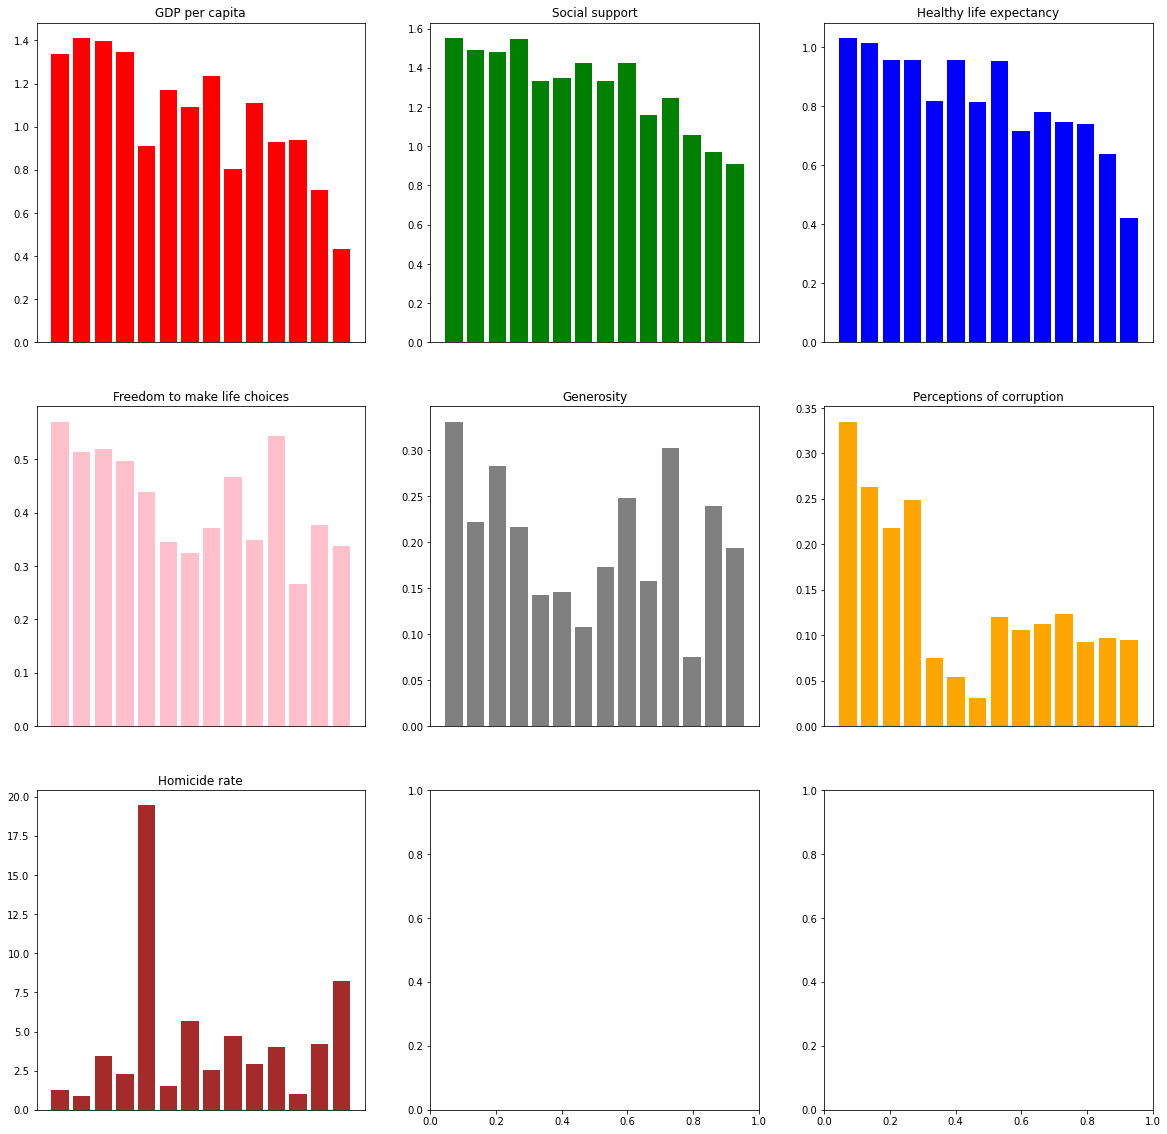

In [24]:
figure, axis = plt.subplots(nrows=3, ncols=3,figsize=(20,20))
axis[0, 0].bar(regionavg_df['subregion'], regionavg_df['avg_GDP'],color='red')
axis[0, 0].set_title("GDP per capita")
axis[0, 0].get_xaxis().set_visible(False)

axis[0, 1].bar(regionavg_df['subregion'], regionavg_df['avg_support'],color='green')
axis[0, 1].set_title("Social support")
axis[0, 1].get_xaxis().set_visible(False)

axis[0, 2].bar(regionavg_df['subregion'], regionavg_df['avg_healthy'],color='blue')
axis[0, 2].set_title("Healthy life expectancy")
axis[0, 2].get_xaxis().set_visible(False)

axis[1, 0].bar(regionavg_df['subregion'], regionavg_df['avg_freedom'],color='pink')
axis[1, 0].set_title("Freedom to make life choices")
axis[1, 0].get_xaxis().set_visible(False)

axis[1, 1].bar(regionavg_df['subregion'], regionavg_df['avg_generosity'],color='grey')
axis[1, 1].set_title("Generosity")
axis[1, 1].get_xaxis().set_visible(False)

axis[1, 2].bar(regionavg_df['subregion'], regionavg_df['avg_corruption'],color='orange')
axis[1, 2].set_title("Perceptions of corruption")
axis[1, 2].get_xaxis().set_visible(False)

axis[2, 0].bar(regionavg_df['subregion'], regionavg_df['avg_deaths'],color='brown')
axis[2, 0].set_title("Homicide rate")
axis[2, 0].get_xaxis().set_visible(False)

plt.show()

In [25]:
quantile_list = happyfactor.approxQuantile('score',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],0.001)
quantile_list

[3.975, 4.456, 4.696, 5.175, 5.373, 5.743, 6.086, 6.3, 7.021]

In [26]:
quantiled_happy = happyfactor.withColumn("quantile",when(happyfactor.score<=quantile_list[0],'p0')
                       .when((quantile_list[0]<happyfactor.score) & (happyfactor.score<=quantile_list[1]), 'p1')
                       .when((quantile_list[1]<happyfactor.score) & (happyfactor.score<=quantile_list[2]), 'p2')
                       .when((quantile_list[2]<happyfactor.score) & (happyfactor.score<=quantile_list[3]), 'p3')
                       .when((quantile_list[3]<happyfactor.score) & (happyfactor.score<=quantile_list[4]), 'p4')
                       .when((quantile_list[4]<happyfactor.score) & (happyfactor.score<=quantile_list[5]), 'p5')
                       .when((quantile_list[5]<happyfactor.score) & (happyfactor.score<=quantile_list[6]), 'p6')
                       .when((quantile_list[6]<happyfactor.score) & (happyfactor.score<=quantile_list[7]), 'p7')
                       .when((quantile_list[7]<happyfactor.score) & (happyfactor.score<=quantile_list[8]), 'p8')
                       .when((quantile_list[8]<=happyfactor.score), 'p9')
                       .otherwise('unknown'))
quantiled_happy.createOrReplaceTempView('quantilehappy')

In [27]:
quantiled_happy.show(5)

+----+-----------+-----+-----+-------+-------+-------+----------+----------+----+------+---------+---------------+--------+
|rank|    country|score|  GDP|support|healthy|freedom|generosity|corruption|Code|deaths|continent|      subregion|quantile|
+----+-----------+-----+-----+-------+-------+-------+----------+----------+----+------+---------+---------------+--------+
|   1|    Finland|7.769| 1.34|  1.587|  0.986|  0.596|     0.153|     0.393| FIN|  1.49|   Europe|Northern Europe|      p9|
|   2|    Denmark|  7.6|1.383|  1.573|  0.996|  0.592|     0.252|      0.41| DNK|  0.75|   Europe|Northern Europe|      p9|
|   3|     Norway|7.554|1.488|  1.582|  1.028|  0.603|     0.271|     0.341| NOR|  0.61|   Europe|Northern Europe|      p9|
|   4|    Iceland|7.494| 1.38|  1.624|  1.026|  0.591|     0.354|     0.118| ISL|  0.68|   Europe|Northern Europe|      p9|
|   5|Netherlands|7.488|1.396|  1.522|  0.999|  0.557|     0.322|     0.298| NLD|  0.84|   Europe| Western Europe|      p9|
+----+--

In [28]:
continent_quantile = sqlc.sql('''
SELECT continent, quantile, COUNT(quantile) AS qnum FROM quantilehappy
WHERE continent IS NOT NULL
GROUP BY continent,quantile
ORDER BY continent, quantile
''')
continent_quantile.createOrReplaceTempView('continentquantile')

In [29]:
continent_quantile.show(5)

+---------+--------+----+
|continent|quantile|qnum|
+---------+--------+----+
|   Africa|      p0|  12|
|   Africa|      p1|   8|
|   Africa|      p2|  11|
|   Africa|      p3|   5|
|   Africa|      p4|   3|
+---------+--------+----+
only showing top 5 rows



In [30]:
continentq_df = continent_quantile.toPandas()

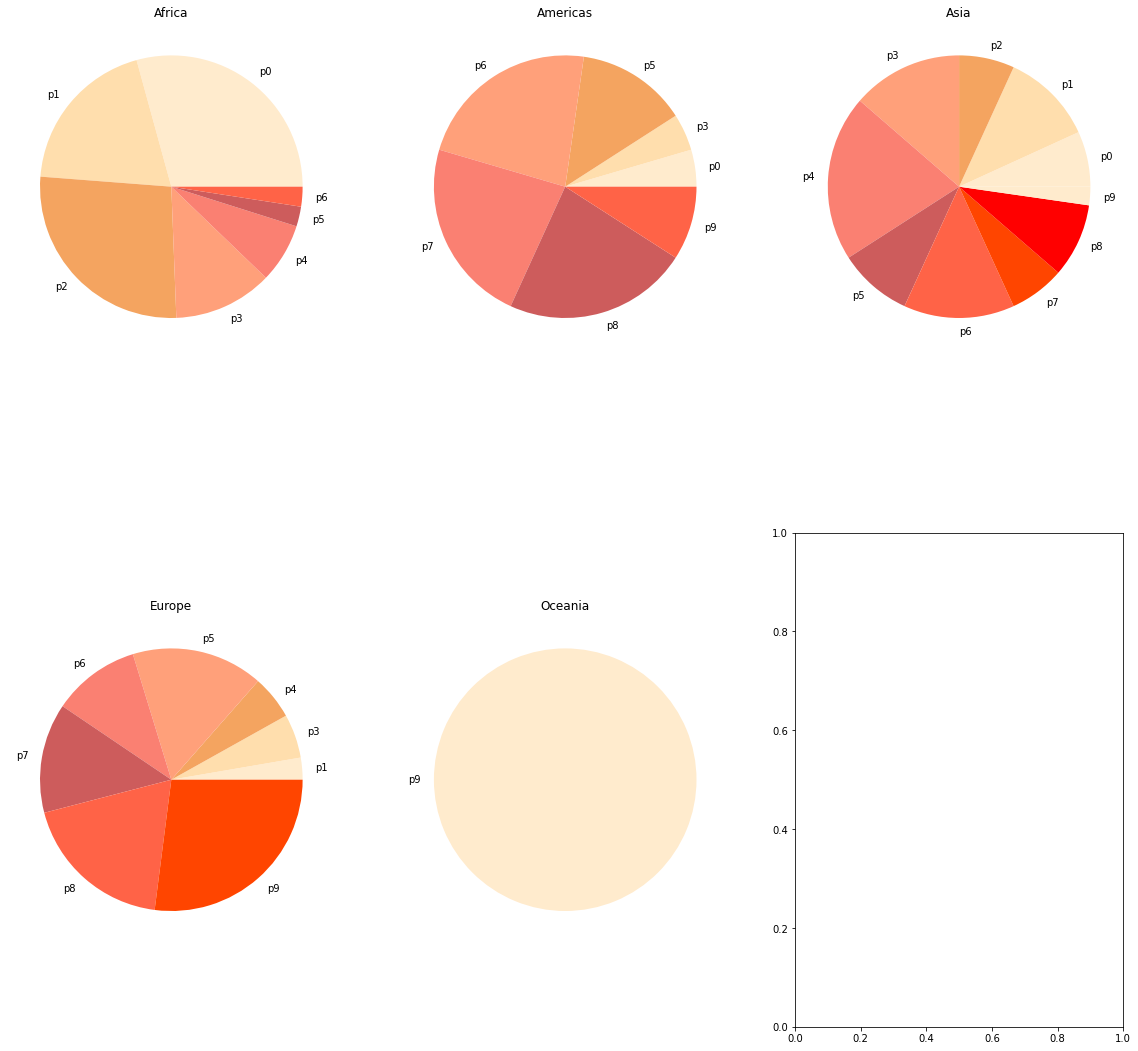

In [31]:
colorsall = np.array(['#FFEBCD','#FFDEAD','#F4A460','#FFA07A','#FA8072','#CD5C5C','#FF6347','#FF4500','#FF0000'])

figure, axis = plt.subplots(nrows=2, ncols=3,figsize=(20,20))
africa = continentq_df[continentq_df['continent']=='Africa']
axis[0, 0].pie(africa['qnum'],labels=africa['quantile'],colors=colorsall[0:len(africa['qnum'])])
axis[0, 0].set_title("Africa")

americas = continentq_df[continentq_df['continent']=='Americas']
axis[0, 1].pie(americas['qnum'],labels=americas['quantile'],colors=colorsall[0:len(americas['qnum'])])
axis[0, 1].set_title("Americas")

asia = continentq_df[continentq_df['continent']=='Asia']
axis[0, 2].pie(asia['qnum'],labels=asia['quantile'],colors=colorsall[0:len(asia['qnum'])])
axis[0, 2].set_title("Asia")

europe = continentq_df[continentq_df['continent']=='Europe']
axis[1, 0].pie(europe['qnum'],labels=europe['quantile'],colors=colorsall[0:len(europe['qnum'])])
axis[1, 0].set_title("Europe")

ocean = continentq_df[continentq_df['continent']=='Oceania']
axis[1, 1].pie(ocean['qnum'],labels=ocean['quantile'],colors=colorsall[0:len(ocean['qnum'])])
axis[1, 1].set_title("Oceania")

plt.show()

In [32]:
continent_quantile.show(10)

+---------+--------+----+
|continent|quantile|qnum|
+---------+--------+----+
|   Africa|      p0|  12|
|   Africa|      p1|   8|
|   Africa|      p2|  11|
|   Africa|      p3|   5|
|   Africa|      p4|   3|
|   Africa|      p5|   1|
|   Africa|      p6|   1|
| Americas|      p0|   1|
| Americas|      p3|   1|
| Americas|      p5|   3|
+---------+--------+----+
only showing top 10 rows



In [33]:
quantile_avg = sqlc.sql('''
SELECT quantile, ROUND(AVG(GDP),5) AS avg_gdp, ROUND(AVG(support),5) AS avg_support, ROUND(AVG(healthy),5) AS avg_healthy, 
ROUND(AVG(freedom),5) AS avg_freedom, ROUND(AVG(generosity),5) AS avg_generosity, ROUND(AVG(corruption),5) AS avg_corruption, 
ROUND(AVG (deaths),5) AS avg_deaths FROM quantilehappy
GROUP BY quantile
ORDER BY quantile, AVG(GDP)
''')
quantile_avg.createOrReplaceTempView('quantileavg')

In [34]:
quantile_avg.show(5)

+--------+-------+-----------+-----------+-----------+--------------+--------------+----------+
|quantile|avg_gdp|avg_support|avg_healthy|avg_freedom|avg_generosity|avg_corruption|avg_deaths|
+--------+-------+-----------+-----------+-----------+--------------+--------------+----------+
|      p0|0.34375|    0.74669|    0.42144|    0.24294|       0.20625|       0.10875|   9.67437|
|      p1|0.57381|    1.01662|    0.47275|     0.3435|       0.21006|       0.08175|   5.88571|
|      p2|0.54573|    0.97927|    0.54427|    0.32373|       0.17013|       0.10793|     6.465|
|      p3|0.74912|    1.08838|    0.60144|    0.39656|       0.17325|       0.07594|     8.075|
|      p4|0.97833|      1.247|    0.75053|    0.33853|       0.16547|       0.06647|   3.34267|
+--------+-------+-----------+-----------+-----------+--------------+--------------+----------+
only showing top 5 rows



In [35]:
qavg_df = quantile_avg.toPandas()
qavg_df

,quantile,avg_gdp,avg_support,avg_healthy,avg_freedom,avg_generosity,avg_corruption,avg_deaths
0,p0,0.34375,0.74669,0.42144,0.24294,0.20625,0.10875,9.67437
1,p1,0.57381,1.01662,0.47275,0.34350,0.21006,0.08175,5.88571
2,p2,0.54573,0.97927,0.54427,0.32373,0.17013,0.10793,6.46500
3,p3,0.74912,1.08838,0.60144,0.39656,0.17325,0.07594,8.07500
4,p4,0.97833,1.24700,0.75053,0.33853,0.16547,0.06647,3.34267
5,p5,0.98725,1.29325,0.81906,0.37956,0.15625,0.08506,6.40214
6,p6,1.11088,1.36256,0.86138,0.42906,0.14500,0.06719,6.77438
7,p7,1.10900,1.42787,0.86480,0.45680,0.16640,0.09927,11.01077
8,p8,1.31100,1.42150,0.91962,0.47131,0.18956,0.13756,6.31000
9,p9,1.36627,1.52660,1.01420,0.54987,0.26800,0.28327,1.68667


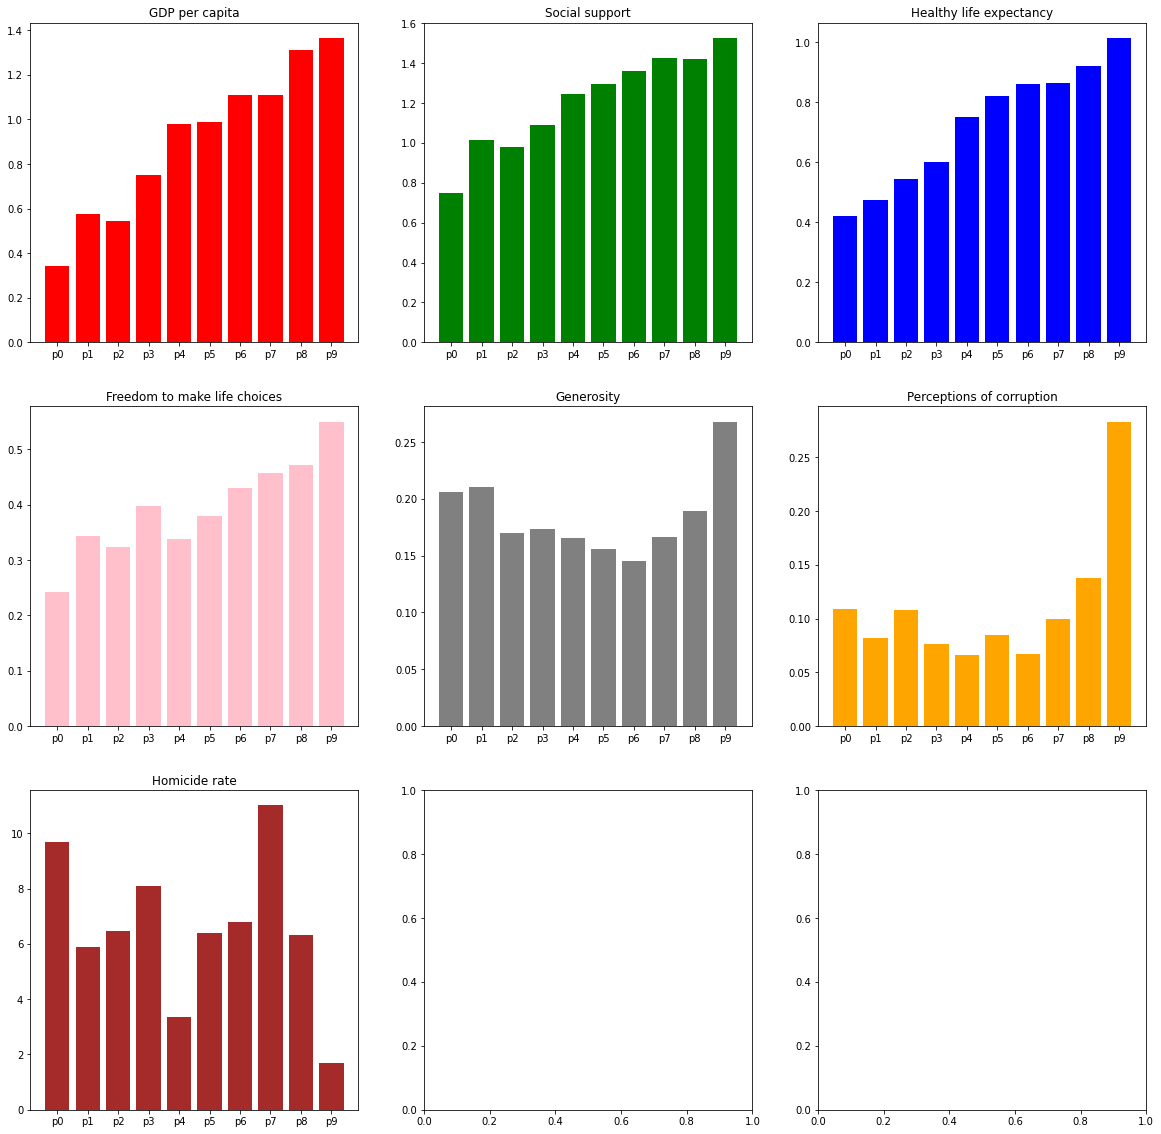

In [36]:
figure, axis = plt.subplots(nrows=3, ncols=3,figsize=(20,20))
axis[0, 0].bar(qavg_df['quantile'], qavg_df['avg_gdp'],color='red')
axis[0, 0].set_title("GDP per capita")

axis[0, 1].bar(qavg_df['quantile'], qavg_df['avg_support'],color='green')
axis[0, 1].set_title("Social support")

axis[0, 2].bar(qavg_df['quantile'], qavg_df['avg_healthy'],color='blue')
axis[0, 2].set_title("Healthy life expectancy")

axis[1, 0].bar(qavg_df['quantile'], qavg_df['avg_freedom'],color='pink')
axis[1, 0].set_title("Freedom to make life choices")

axis[1, 1].bar(qavg_df['quantile'], qavg_df['avg_generosity'],color='grey')
axis[1, 1].set_title("Generosity")

axis[1, 2].bar(qavg_df['quantile'], qavg_df['avg_corruption'],color='orange')
axis[1, 2].set_title("Perceptions of corruption")

axis[2, 0].bar(qavg_df['quantile'], qavg_df['avg_deaths'],color='brown')
axis[2, 0].set_title("Homicide rate")

plt.show()